# Title: 
## Forecasting Global Active Power Using Machine Learning

## Objective:

#### Develop a machine learning model to accurately forecast Global Active Power (GAP) consumption based on historical data.



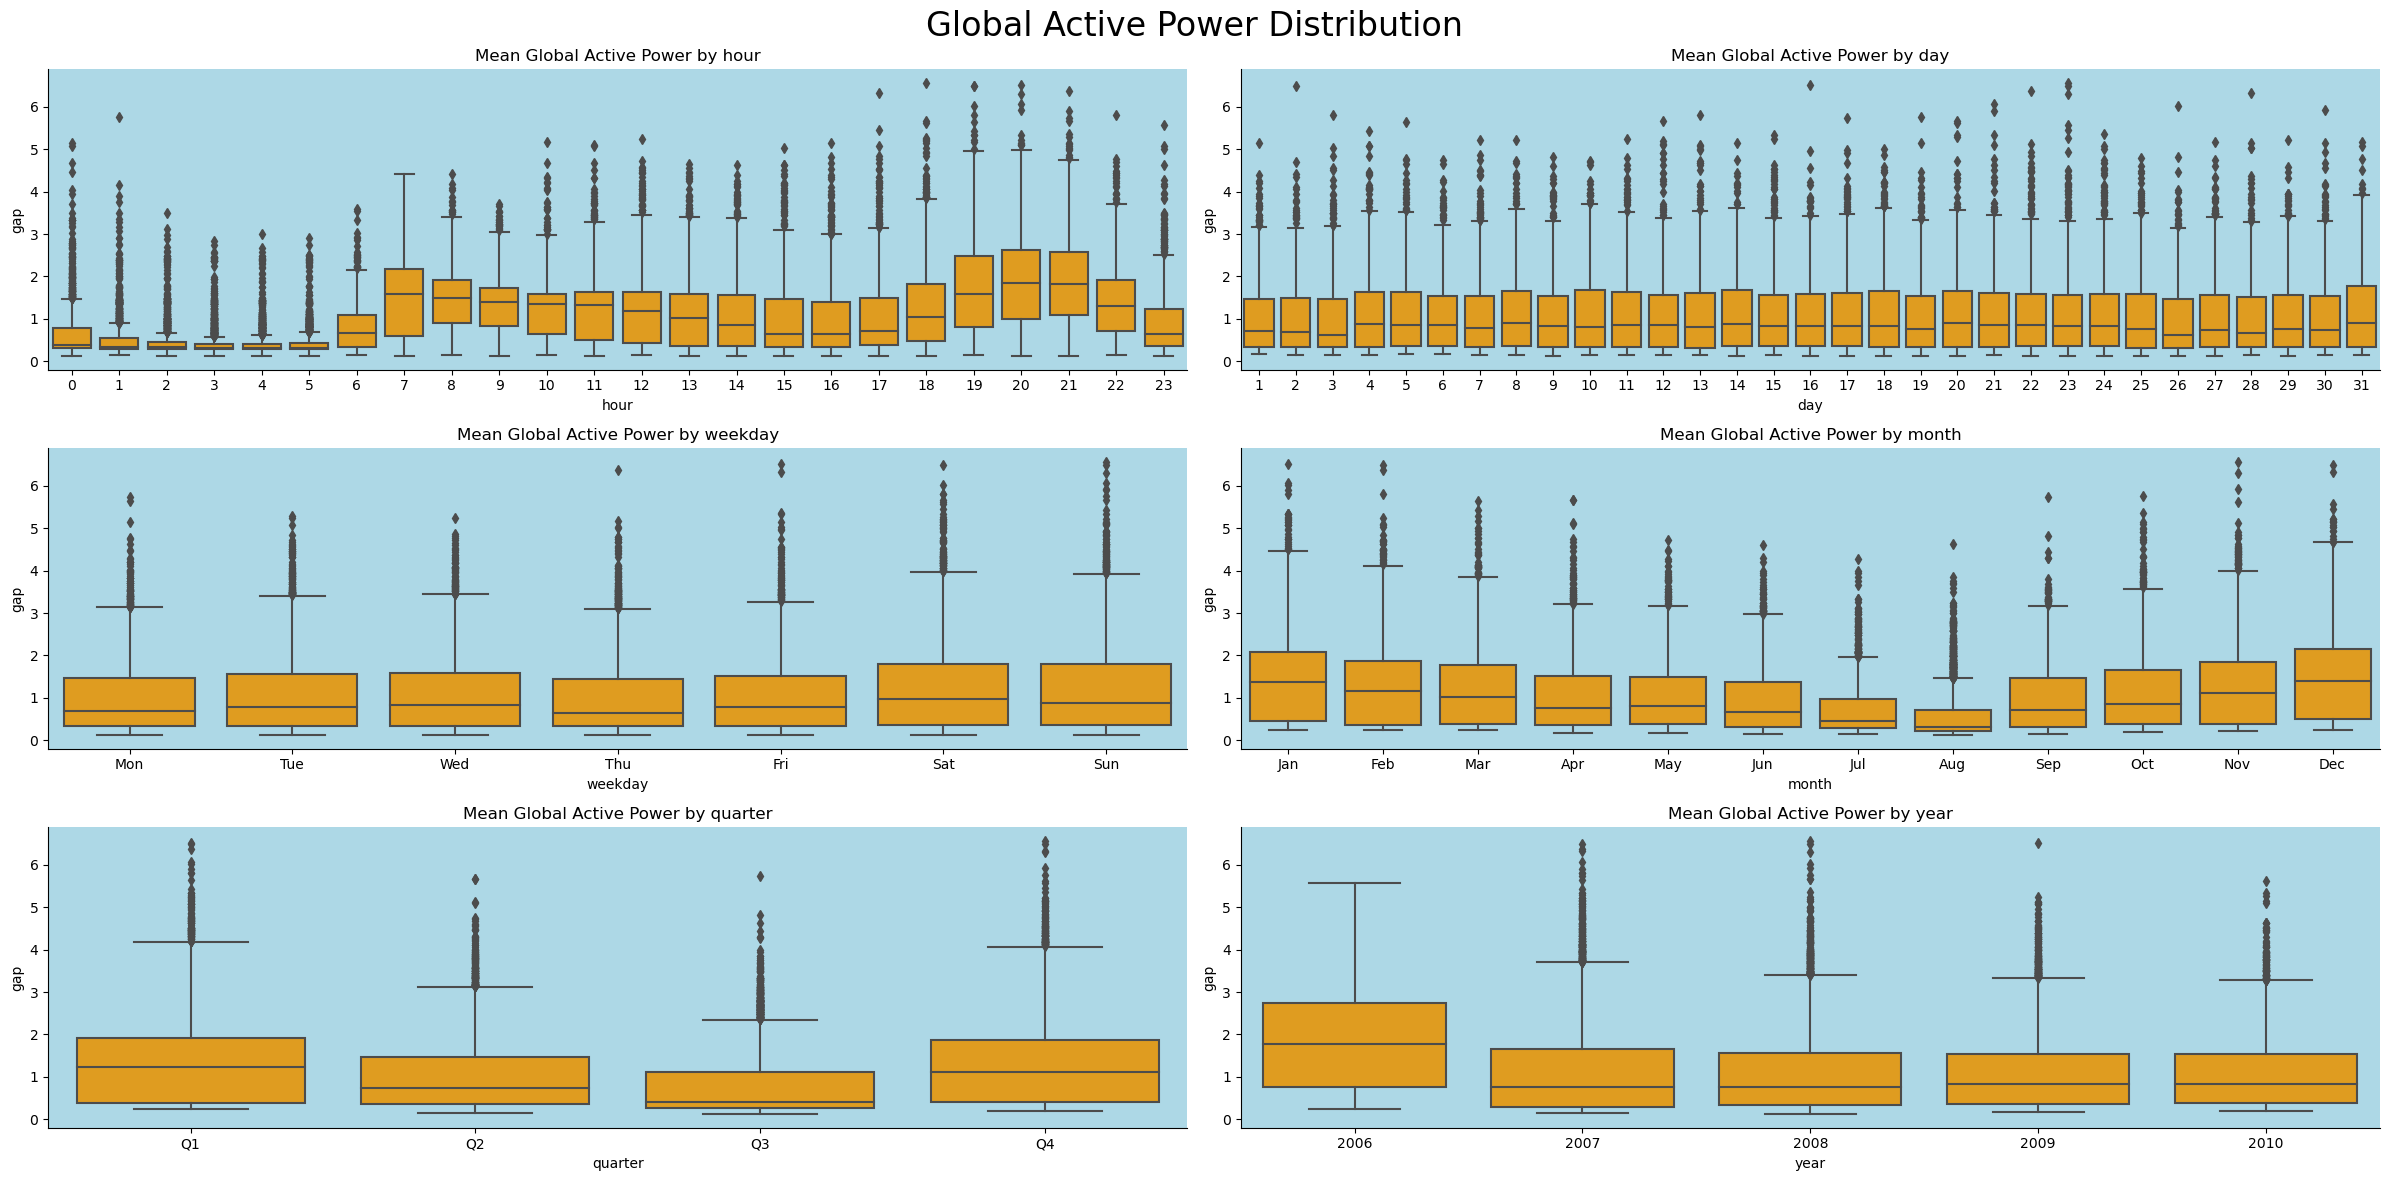


In [72]:
import os
from typing import Tuple, Union, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# stats libraries
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller



from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#set plot style
plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'lightblue',
    'legend.loc': 'upper left'
})

### Load Dataset

In [73]:
filepath = os.path.expanduser(
    '~/data/energy_dataset/household_power_consumption.txt')
df_power = pd.read_csv(filepath, low_memory=False,
                       delimiter=';', na_values=['?'])
df_power['datetime'] = pd.to_datetime(
    df_power['Date'] + ' ' + df_power['Time'], format='%d/%m/%Y %H:%M:%S')
df_power.set_index('datetime', inplace=True)
df_power.drop(columns=['Date', 'Time', 
            'Global_reactive_power', 
            'Voltage',
            'Global_intensity', 
            'Sub_metering_1', 
            'Sub_metering_2', 
            'Sub_metering_3'], 
            inplace=True)
df_power = df_power.rename(columns={'Global_active_power': 'gap'})
df_power.head()

,gap
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


### Resample data to Daily Average Power Output

In [74]:
df_power = df_power.resample('h').mean()
df_power.head()

,gap
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


### Data & Feature Exploration

In [75]:
df_power = df_power.dropna()

Text(0.5, 1.0, 'Global Active Power')

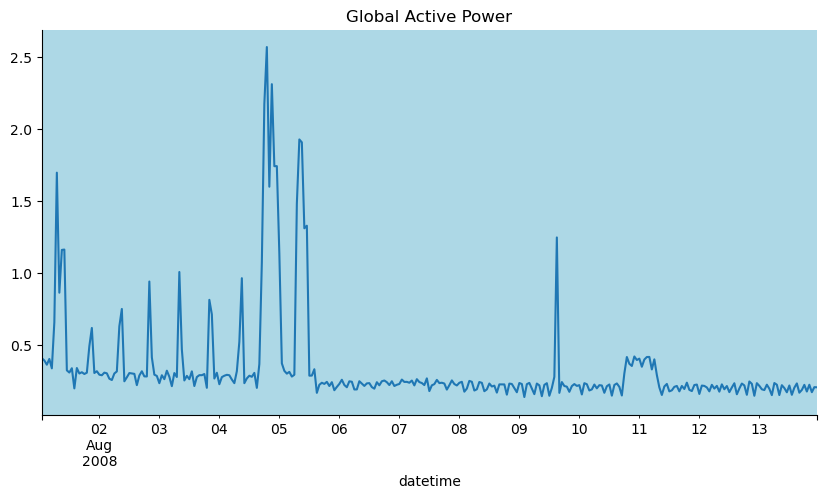

In [76]:
mask = (df_power.index > '2008-08-01') & (df_power.index < '2008-08-14')
df_power.loc[mask, 'gap'].plot(figsize=(10, 5))
plt.title('Global Active Power')


Text(0.5, 1.0, 'Distribution of Global Active Power')

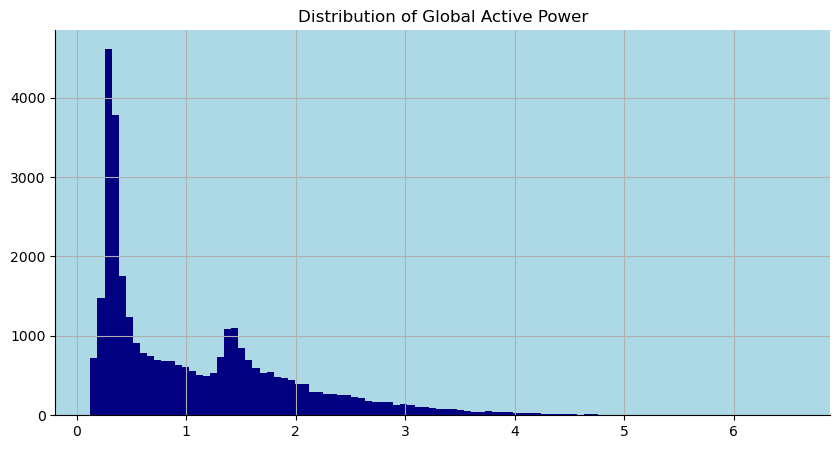

In [77]:
df_power.gap.hist(bins=100, figsize=(10, 5), color='navy')
plt.title('Distribution of Global Active Power')

### Create Features

In [78]:
df_power['hour'] = df_power.index.hour
df_power['day'] = df_power.index.day
df_power['weekday'] = df_power.index.weekday
df_power['month'] = df_power.index.month
df_power['quarter'] = df_power.index.quarter
df_power['year'] = df_power.index.year

In [79]:
df_power.head()

,gap,hour,day,weekday,month,quarter,year
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,17,16,5,12,4,2006
2006-12-16 18:00:00,3.632200,18,16,5,12,4,2006
2006-12-16 19:00:00,3.400233,19,16,5,12,4,2006
2006-12-16 20:00:00,3.268567,20,16,5,12,4,2006
2006-12-16 21:00:00,3.056467,21,16,5,12,4,2006


### Plot Correlation of features with Global Active Power

In [80]:
def plot_feature_correlaion(df: pd.DataFrame, feature: str) -> None:
    corr = df.corrwith(df[feature]).sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=corr[1:].values, y=corr[1:].index, palette='viridis')
    plt.title(f'Feature Correlation with {feature}')
    plt.show()

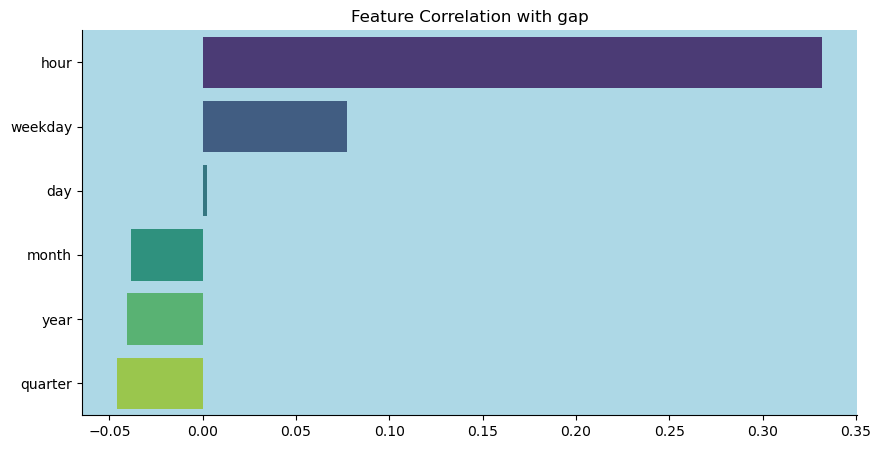

In [81]:
plot_feature_correlaion(df_power, 'gap')

In [82]:
df_power_map = df_power.copy()

weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
quarter_map = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

df_power_map['weekday'] = df_power_map['weekday'].map(weekday_map)
df_power_map['month'] = df_power_map['month'].map(month_map)
df_power_map['quarter'] = df_power_map['quarter'].map(quarter_map)

df_power_map.head()

,gap,hour,day,weekday,month,quarter,year
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,17,16,Sat,Dec,Q4,2006
2006-12-16 18:00:00,3.632200,18,16,Sat,Dec,Q4,2006
2006-12-16 19:00:00,3.400233,19,16,Sat,Dec,Q4,2006
2006-12-16 20:00:00,3.268567,20,16,Sat,Dec,Q4,2006
2006-12-16 21:00:00,3.056467,21,16,Sat,Dec,Q4,2006


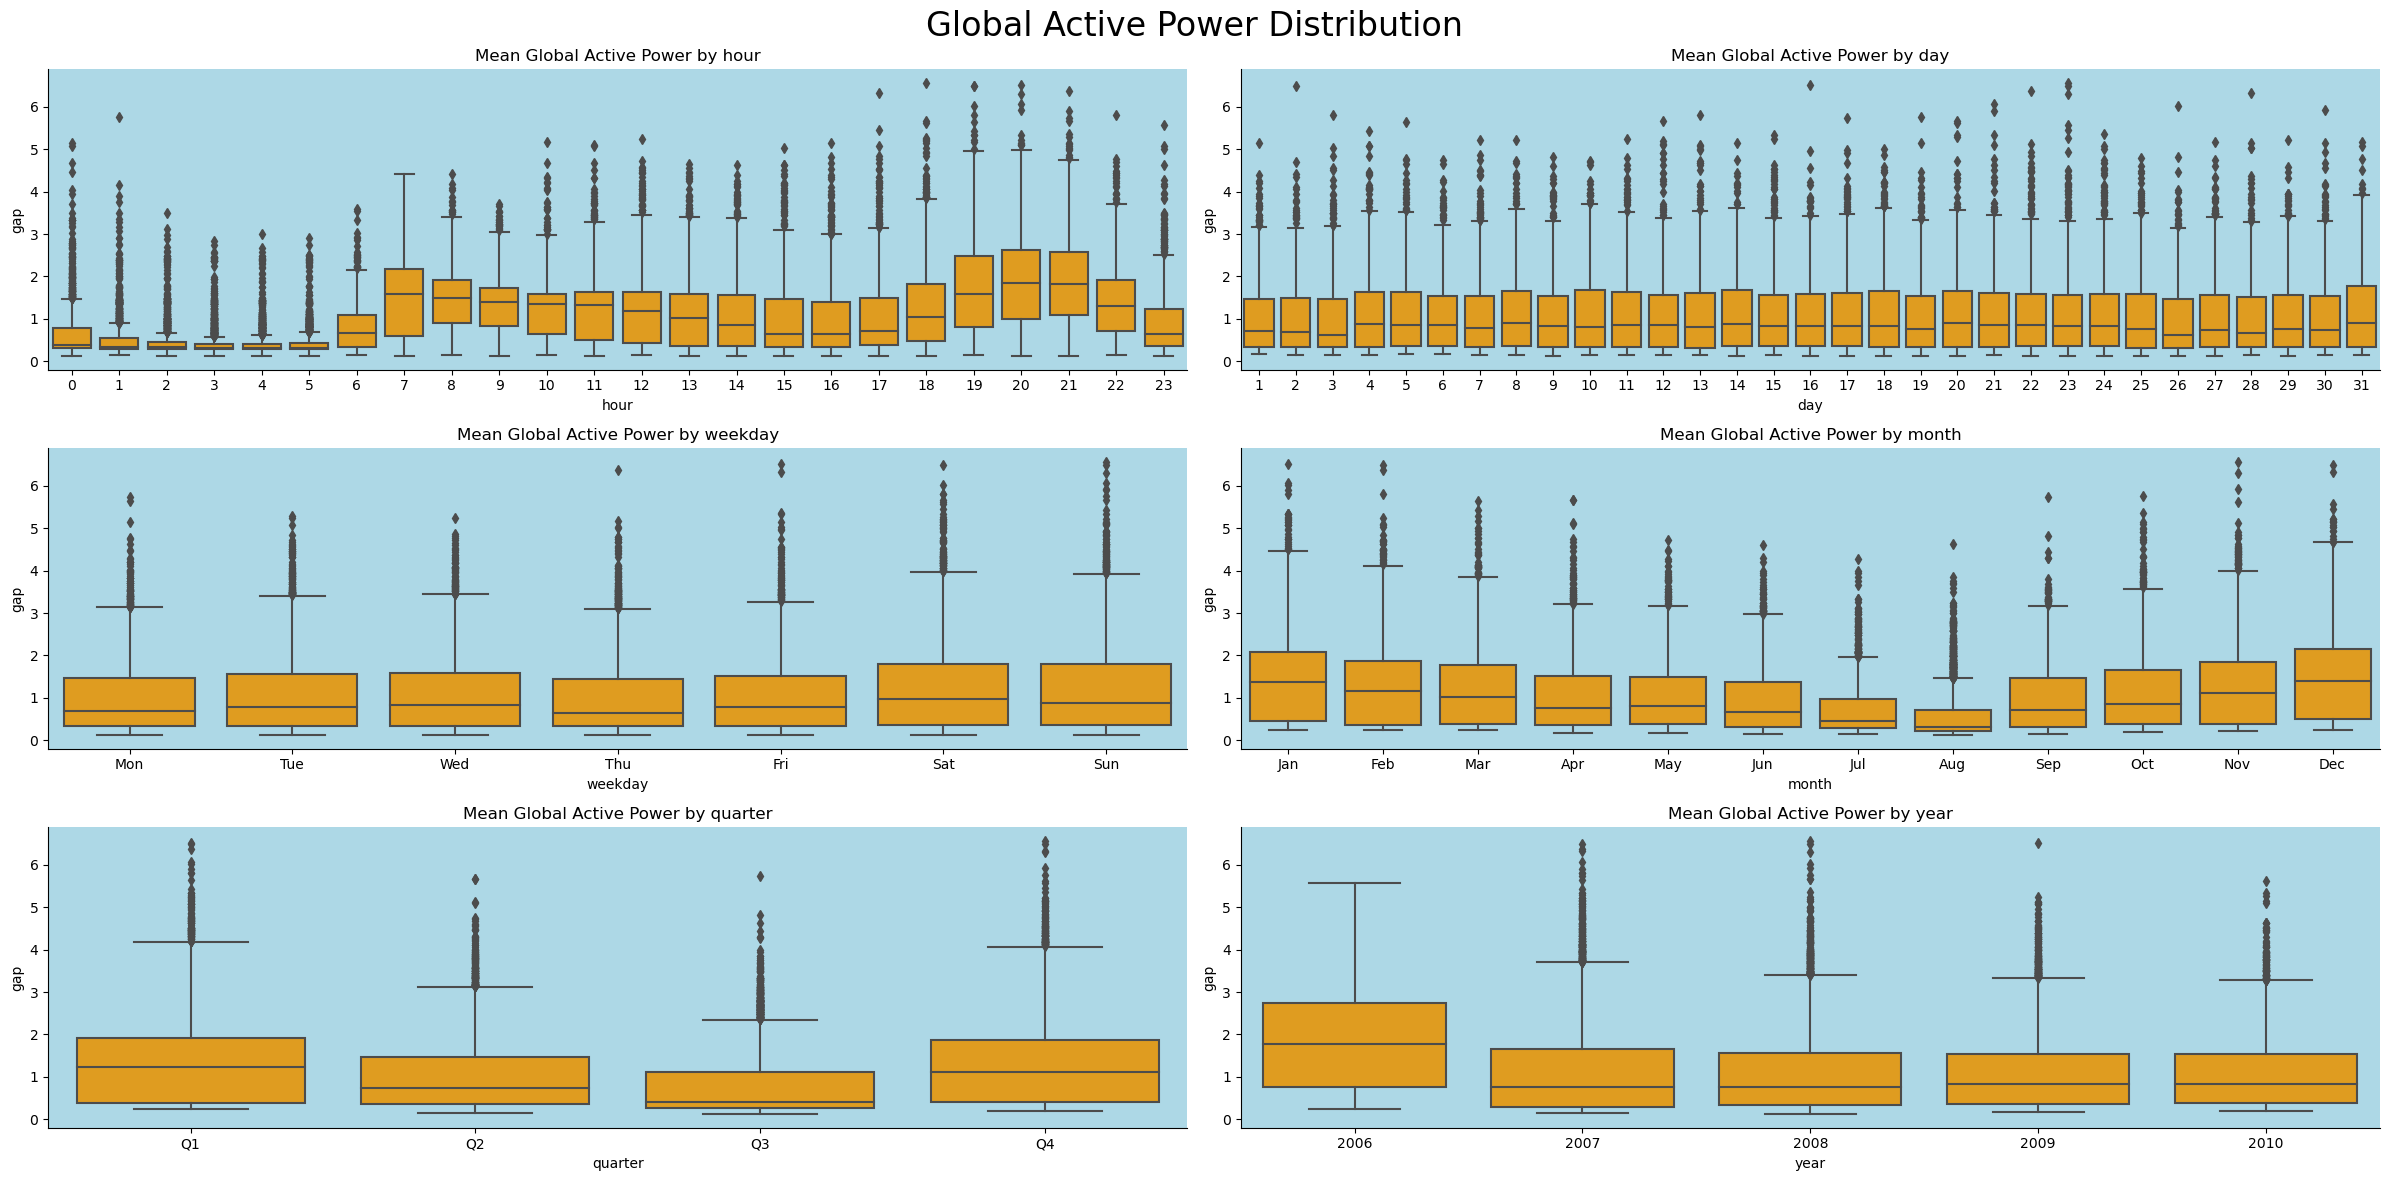

In [83]:
def plot_feature_distribution(df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 12))
    fig.suptitle('Global Active Power Distribution', fontsize=24)
    for i, col in enumerate(df.columns[1:]):
        axes.flatten()[i].set_title(f'Mean Global Active Power by {col}')
        if col == 'weekday':
            sns.boxplot(data=df, x=col, y='gap',
                        color='orange', ax=axes.flatten()[i],
                        order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) 
        elif col == 'month':
            sns.boxplot(data=df, x=col, y='gap',
                        color='orange', ax=axes.flatten()[i],
                        order=['Jan', 'Feb', 'Mar', 'Apr',
                               'May', 'Jun', 'Jul', 'Aug',
                               'Sep', 'Oct', 'Nov', 'Dec'])
        elif col == 'quarter':
            sns.boxplot(data=df, x=col, y='gap',
                        color='orange', ax=axes.flatten()[i],
                        order=['Q1', 'Q2', 'Q3', 'Q4'])
        else:
             sns.boxplot(data=df, x=col, y='gap',
                    color='orange', ax=axes.flatten()[i])
       
        plt.tight_layout()
   
plot_feature_distribution(df_power_map)

### Split the Dataset for Training & Validation

In [180]:
def split_data(df: pd.DataFrame, split_date: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    mask_train_valid = df.index < split_date
    mask_test = df.index >= split_date
    train_valid = df.loc[mask_train_valid].copy()
    test_df = df.loc[mask_test].copy()
    train_df, valid_df = train_test_split(
        train_valid, test_size=0.15, shuffle=False, random_state=13)

    return train_df, valid_df, test_df

In [181]:
train_df, valid_df, test_df = split_data(df_power, '2010-01-01')
train_df.shape, valid_df.shape, test_df.shape

((22559, 6), (3982, 6), (7627, 6))

### Model Training

In [182]:
X = train_df.drop(columns='gap')
y = train_df.gap

X_valid = valid_df.drop(columns='gap')
y_valid = valid_df.gap

X_test = test_df.drop(columns='gap')
y_test = test_df.gap

In [183]:
lgm = LGBMRegressor(n_estimators=100, learning_rate=0.1,
                    random_state=13, importance_type='gain')
model = lgm.fit(X, y, eval_set=[(X_valid, y_valid)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 22559, number of used features: 5
[LightGBM] [Info] Start training from score 1.110191


In [184]:
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f'MAE: {mae:.2f} | MSE: {mse:.2f} | R2: {r2:.2f}')

MAE: 0.45 | MSE: 0.38 | R2: 0.37


In [185]:
test_df['gap_pred'] = pred


### Check Residual Distribution (Normality)

<Axes: >

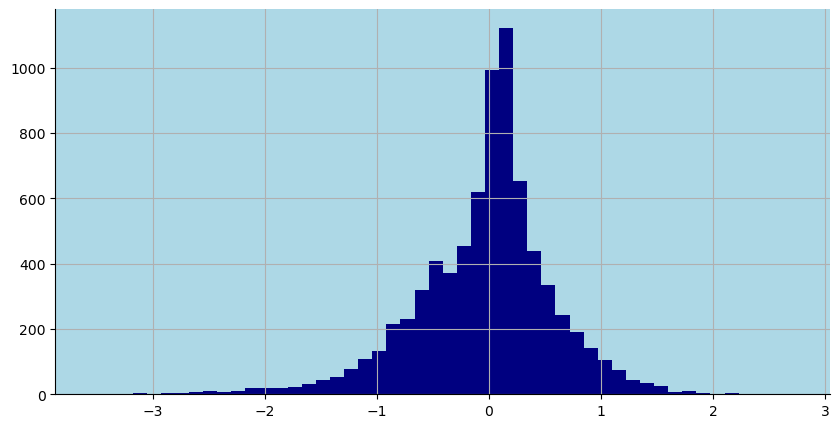

In [186]:
(pred - y_test).hist(bins=50, figsize=(10, 5), color='navy')

### Visualization - Overlay prediction to actual values

Text(0.5, 1.0, 'Global Active Power vs Predicted Global Active Power')

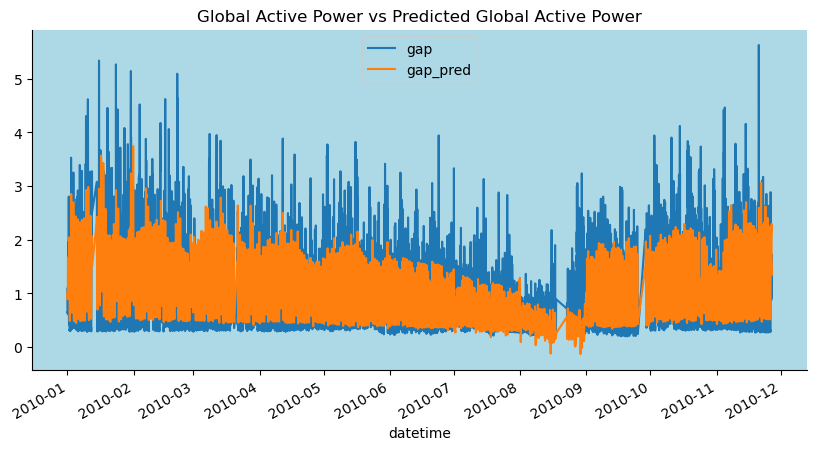

In [187]:
test_df[['gap', 'gap_pred']].plot(figsize=(10, 5))
plt.title('Global Active Power vs Predicted Global Active Power')

#### Closer look

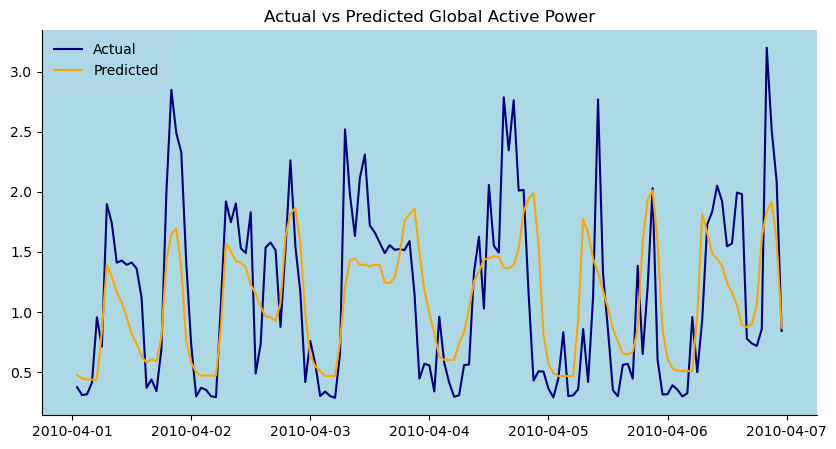

In [188]:
min_date = '2010-04-01'
max_date = '2010-04-07'

mask = (test_df.index > min_date) & (test_df.index < max_date)

plt.figure(figsize=(10, 5))
plt.plot(test_df.loc[mask].index, test_df.loc[mask, 'gap'], label='Actual', color='navy')
plt.plot(test_df.loc[mask].index, pred[mask], label='Predicted', color='orange')
plt.title('Actual vs Predicted Global Active Power')
plt.legend()
plt.show()

### Check Fearture Importance

Text(0.5, 1.0, 'Feature Importance')

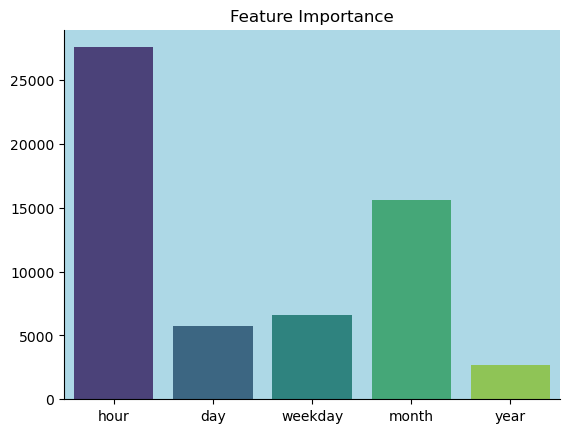

In [189]:
sns.barplot(x=X.columns, y=model.feature_importances_, palette='viridis')
plt.title('Feature Importance')

    Prediciton is currently just a regression and we need to add temporal components to model a typical time series data.
    We can introduce lags.

In [201]:
def define_lags(df: pd.DataFrame, col: str, lags: Union[int, List[int]]) -> None:
    if isinstance(lags, int):
        lags = [lags]

    lag_cols = df.filter(like=f'{col}_lag').columns
    df.drop(columns=lag_cols, inplace=True)
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df.fillna(0, inplace=True) 
    return df

In [202]:
define_lags(df_power, 'gap', [1,2,3])

,gap,hour,day,weekday,month,year,gap_lag_1,gap_lag_2,gap_lag_3
datetime,,,,,,,,,
2006-12-16 17:00:00,4.222889,17,16,5,12,2006,0.000000,0.000000,0.000000
2006-12-16 18:00:00,3.632200,18,16,5,12,2006,4.222889,0.000000,0.000000
2006-12-16 19:00:00,3.400233,19,16,5,12,2006,3.632200,4.222889,0.000000
2006-12-16 20:00:00,3.268567,20,16,5,12,2006,3.400233,3.632200,4.222889
2006-12-16 21:00:00,3.056467,21,16,5,12,2006,3.268567,3.400233,3.632200
...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,17,26,4,11,2010,1.067933,0.876433,1.407767
2010-11-26 18:00:00,1.573467,18,26,4,11,2010,1.725900,1.067933,0.876433
2010-11-26 19:00:00,1.659333,19,26,4,11,2010,1.573467,1.725900,1.067933


### Split data for training 

In [203]:
train_df, valid_df, test_df = split_data(df_power, '2010-01-01')
train_df.shape, valid_df.shape, test_df.shape

((22559, 9), (3982, 9), (7627, 9))

In [205]:
X = train_df.drop(columns='gap')
y = train_df.gap

X_valid = valid_df.drop(columns='gap')
y_valid = valid_df.gap

X_test = test_df.drop(columns='gap')
y_test = test_df.gap

In [206]:
lgm = LGBMRegressor(n_estimators=100, learning_rate=0.1,
                    random_state=13, importance_type='gain')
model = lgm.fit(X, y, eval_set=[(X_valid, y_valid)])


pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f'MAE: {mae:.2f} | MSE: {mse:.2f} | R2: {r2:.2f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 22559, number of used features: 8
[LightGBM] [Info] Start training from score 1.110191
MAE: 0.34 | MSE: 0.24 | R2: 0.61


<Axes: >

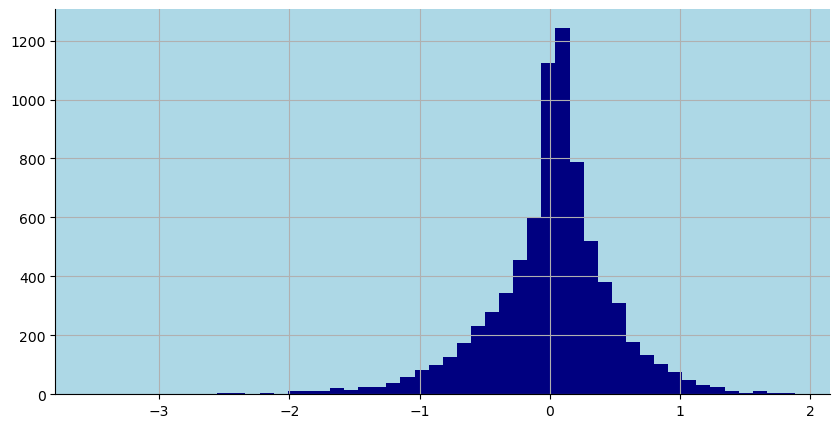

In [207]:
test_df['gap_pred'] = pred
(pred - y_test).hist(bins=50, figsize=(10, 5), color='navy')

Text(0.5, 1.0, 'Feature Importance')

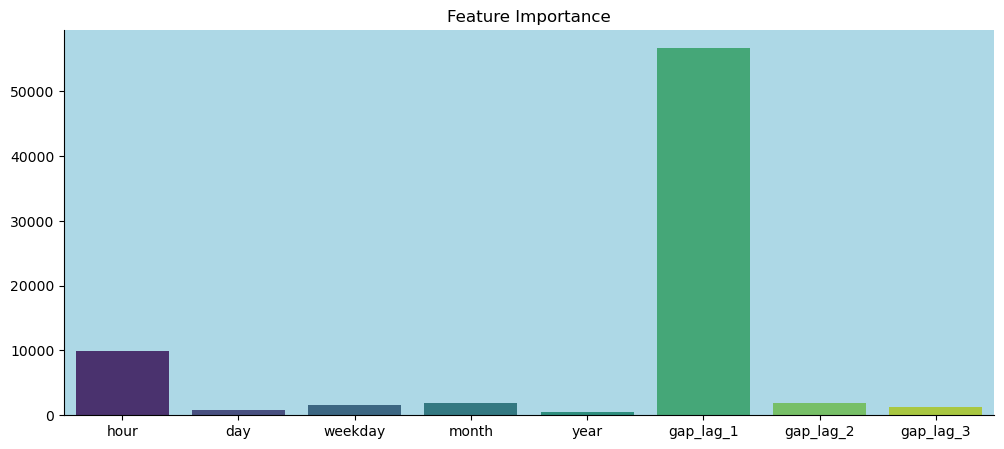

In [211]:
plt.figure(figsize=(12, 5))
sns.barplot(x=X.columns, y=model.feature_importances_, palette='viridis')
plt.title('Feature Importance')

Text(0.5, 1.0, 'Global Active Power vs Predicted Global Active Power')

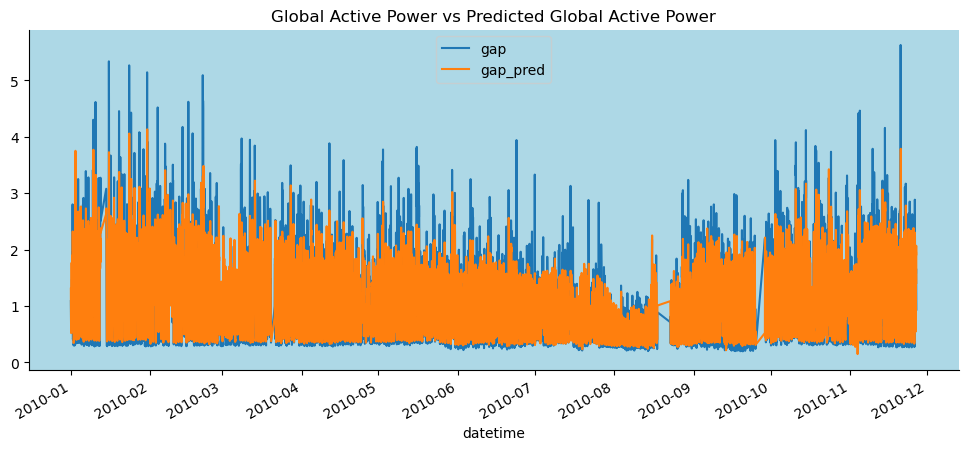

In [213]:
test_df[['gap', 'gap_pred']].plot(figsize=(12, 5))
plt.title('Global Active Power vs Predicted Global Active Power')

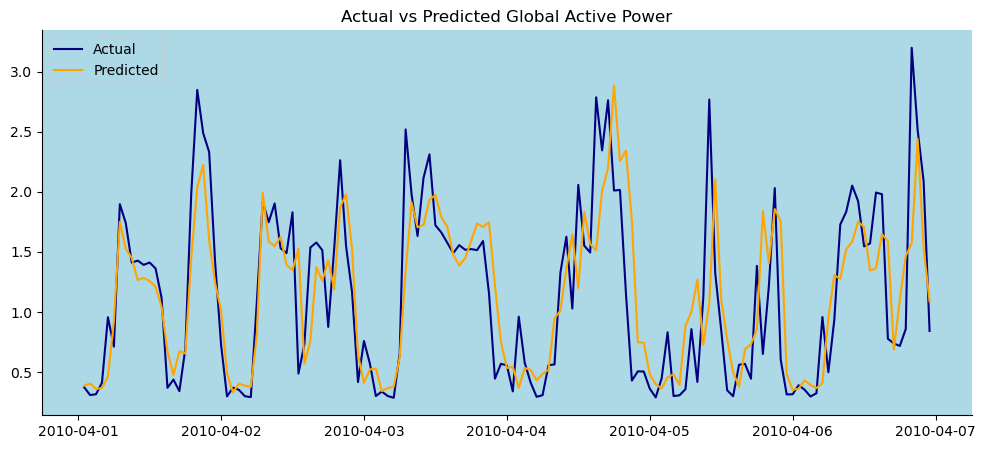

In [214]:
min_date = '2010-04-01'
max_date = '2010-04-07'

mask = (test_df.index > min_date) & (test_df.index < max_date)

plt.figure(figsize=(12, 5))
plt.plot(test_df.loc[mask].index, test_df.loc[mask, 'gap'], label='Actual', color='navy')
plt.plot(test_df.loc[mask].index, pred[mask], label='Predicted', color='orange')
plt.title('Actual vs Predicted Global Active Power')
plt.legend()
plt.show()